In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pickle
import os.path as path

import timeit


from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

0 Liver_map_150z25_60s_#12.npy
Time:  1.4506050250001863
Time:  0.2878252219998103
Time:  0.14158474400028354


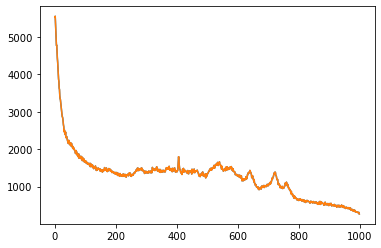

Time:  71.94703808699978


In [13]:
filename_lst = []
file_location = '../data/Raman_Mouse/'
for i, file in enumerate(glob.glob(f'{file_location}raw/*')):
    filename_lst.append(file.split('/')[-1].split('\\')[-1].split('.')[0] + '.npy')
    print(i, filename_lst[-1])

#     if path.exists(f'{file_location}raw_npy/{filename_lst[-1]}') and i!=0:
#         continue
    start = timeit.default_timer()
    
    df = pd.read_csv(file, delimiter='\t', skipinitialspace=True, header=0, skiprows=[])
    data = df.to_numpy()[:,:4]
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    start = timeit.default_timer()
    
    if i == 0:
        X = np.array(sorted(list(np.unique(data[:,0]))))
        Y = np.array(sorted(list(np.unique(data[:,1]))))
        X_0 = X - X[0]
        Y_0 = Y - Y[0]
        Wavelength = sorted(list(np.unique(data[:,2])))
        np.save(f'{file_location}X_coordinates', X) 
        np.save(f'{file_location}Y_coordinates', Y)
    else:
        try:
            X = np.array(sorted(list(np.unique(data[:,0]))))
            Y = np.array(sorted(list(np.unique(data[:,1]))))
            x_0 = X - X[0]
            y_0 = Y - Y[0]
            assert (X_0 == x_0).all(), f"X is not equal for file {file}"
            assert (Y_0 == y_0).all(), f"Y is not equal for file {file}"
        except AssertionError:
            print("X difference:", X_0 - x_0)
            print("Y difference:", Y_0 - y_0)
        except AttributeError:
            print("Corrupted File")
            continue

    stop = timeit.default_timer()
    print('Time: ', stop - start)
    start = timeit.default_timer()
            
#     if i==0 and path.exists(f'{file_location}raw_npy/{filename_lst[-1]}'):
#         continue

    wavelength = sorted(list(np.unique(data[:,2])))
    np.save(f'{file_location}raw_npy/{filename_lst[-1].split(".")[0]}_Wavenumbers', wavelength) 
    
    # detected if a point is missing (the value is than -100)
    img = np.zeros((len(X), len(Y), len(wavelength)), dtype=np.float64) - 100

    stop = timeit.default_timer()
    print('Time: ', stop - start)
    start = timeit.default_timer()
    
#     for d in data:
#         i = list(X).index(d[0])
#         j = list(Y).index(d[1])
#         w = wavelength.index(d[2])
#         img[i,j,w] = d[3]
        
    data = data[:,3]
    data = data.reshape(len(Y), len(X), len(wavelength))
    data = np.rollaxis(data, 1, 0)
    data = data[:,:,::-1]
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)
        
#     np.save(f'{file_location}raw_npy/{filename_lst[-1]}', img) 

#     stop = timeit.default_timer()
#     print('Time: ', stop - start)
#     start = timeit.default_timer()

np.save(f'{file_location}raw_npy/FileNames', filename_lst)

In [ ]:
filename_lst = np.load(f"{file_location}raw_npy/FileNames.npy")
df = pd.read_csv('../data/Raman_Mouse/Sample_labels.csv', delimiter=',', skipinitialspace=True, header=0, skiprows=[])
# only need which sample, gender, tissue type and age.
data = df.to_numpy()[:,[0,2,4,6]]

In [ ]:
tissue_dict = {'Liver' : [1,0,0], 'Muscle' : [0,1,0], 'Kidney' : [0,0,1]}
labels = {}
for file in filename_lst:
    try:
        specimen_number = int(file.split("#")[1][:2])
    except ValueError:
        specimen_number = int(file.split("#")[1][0])
    index = list(data[:,0]).index(specimen_number)
    V_M = int(data[index, 1] == 'M')
    L_M_K = tissue_dict[data[index, 2]] 
    
    labels[f"{file.split('.')[0]}.npy"] = (V_M, *L_M_K, data[index, 3])

with open('../data/Raman_Mouse/Sample_labels.pickle', 'wb') as f:
    pickle.dump(labels, f)